# I. First

In [9]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [10]:
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

In [11]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import Annotated
from langchain_groq import ChatGroq
from typing_extensions import TypedDict

In [12]:
from typing import Annotated

# from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatGroq(model_name = 'llama-3.1-8b-instant', api_key = GROQ_API_KEY)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

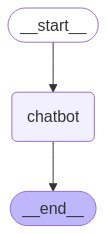

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: It seems like you didn't ask a question. How can I assist you today?
Assistant: It seems like you haven't asked a question or provided any context for our conversation. How can I assist you today?
Assistant: It seems like you might have intended to ask a question, but it appears to be missing. Please feel free to ask a question or start a conversation, and I'll do my best to assist you.
Assistant: It seems like you forgot to ask a question. How can I assist you today?
Assistant: There are many ways to interpret "escape." Here are a few possibilities:

1. **Physical Escape**: To physically escape from a place or situation, you might need to find a way out, like unlocking a door, breaking free from restraints, or escaping through a window.
2. **Mental Escape**: To mentally escape from stress, anxiety, or other emotional burdens, you might need to find healthy coping mechanisms, such as meditation, exercise, or creative pursuits.
3. **Virtual Escape**: To virtually escape throu

# II. Prebuilt Agent


In [10]:
print(api_call('chicken'))

Fatty acids, total trans: 0.0 g
Carbohydrate, by difference: 0.0 g
Protein: 21.43 g
Vitamin C, total ascorbic acid: 0.0 mg
Total lipid (fat): 1.79 g
Fiber, total dietary: 0.0 g
Calcium, Ca: 0.0 mg
Energy: 107.0 kcal
Iron, Fe: 0.0 mg
Vitamin A, IU: 0.0 IU
Total Sugars: 0.0 g
Fatty acids, total saturated: 0.89 g
Sodium, Na: 179.0 mg
Cholesterol: 45.0 mg



In [25]:
from langchain_groq import ChatGroq
import requests
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent

model = ChatGroq(model="llama-3.3-70b-specdec")
USDA_API_KEY = os.getenv("USDA_API_KEY")

# Create specialized agents

def api_call(food_name: str) -> str:
    """Get the nutrition information for a food item."""
    url = f"https://api.nal.usda.gov/fdc/v1/foods/search?query={food_name}&api_key={USDA_API_KEY}"
    response = requests.get(url)
    data = response.json()
    food_id = data["foods"][0]["fdcId"]

    food_url = f"https://api.nal.usda.gov/fdc/v1/food/{food_id}?api_key={USDA_API_KEY}"
    food_response = requests.get(food_url)
    food_data = food_response.json()
    nutrition_infos = food_data["foodNutrients"]
    food_nutrition = ''
    for nutrition_info in nutrition_infos:
        nutrient = nutrition_info['nutrient']
        nutrient_name = nutrient['name']
        nutrient_value = nutrition_info['amount']
        nutrient_unit = nutrient['unitName']
        # print(f"{nutrient_name}: {nutrient_value} {nutrient_unit}")
    ######
        food_nutrition += f"{nutrient_name}: {nutrient_value} {nutrient_unit}\n"
    return food_nutrition# Placeholder for actual API call

food_agent = create_react_agent(
    model=model,
    tools=[api_call],
    name="nutrition_expert",
    prompt="You are a nutrition expert. Always use one tool at a time."
)

# # Create supervisor workflow
workflow = create_supervisor(
    [food_agent],
    model=model,
    prompt=(
        "You are a team supervisor managing a nutrition expert."
        "For current events, use nutrition_expert. "
        "For other events, use the default agent."
        "show the user the nutrition information you got from the nutrition expert."
    )
)

# # Compile and run
app = workflow.compile()
result = app.invoke({
    "messages": [
        {
            "role": "user",
            "content": "i need nutrition of chicken"
        }
    ]
})

In [40]:
print(result)

{'messages': [HumanMessage(content='i need nutrition of chicken', additional_kwargs={}, response_metadata={}, id='fcab30a0-6a21-4059-868c-0204d2d90b9d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wp3g', 'function': {'arguments': '{}', 'name': 'transfer_to_nutrition_expert'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 255, 'total_tokens': 269, 'completion_time': 0.013914545, 'prompt_time': 0.025947191, 'queue_time': 0.235734708, 'total_time': 0.039861736}, 'model_name': 'llama-3.3-70b-specdec', 'system_fingerprint': 'fp_985f1e4133', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run-bf1cfdd2-5896-4a37-8866-9154019c0fa3-0', tool_calls=[{'name': 'transfer_to_nutrition_expert', 'args': {}, 'id': 'call_wp3g', 'type': 'tool_call'}], usage_metadata={'input_tokens': 255, 'output_tokens': 14, 'total_tokens': 269}), ToolMessage(content='Successfully transferred to nutrition_expert', name

In [41]:
# Hiển thị toàn bộ messages từ result
for message in result["messages"]:
    
    print(message.content)


i need nutrition of chicken

Successfully transferred to nutrition_expert
Here is the nutrition information for chicken:

* Fatty acids, total trans: 0.0 g
* Carbohydrate, by difference: 0.0 g
* Protein: 21.43 g
* Vitamin C, total ascorbic acid: 0.0 mg
* Total lipid (fat): 1.79 g
* Fiber, total dietary: 0.0 g
* Calcium, Ca: 0.0 mg
* Energy: 107.0 kcal
* Iron, Fe: 0.0 mg
* Vitamin A, IU: 0.0 IU
* Total Sugars: 0.0 g
* Fatty acids, total saturated: 0.89 g
* Sodium, Na: 179.0 mg
* Cholesterol: 45.0 mg

Please note that the exact nutrition information may vary depending on the specific type and cut of chicken, as well as any cooking methods or seasonings used. If you have any specific questions or concerns, feel free to ask!
Transferring back to supervisor
Successfully transferred back to supervisor
I hope the nutrition information for chicken was helpful. Let me know if you have any other questions or if there's anything else I can help you with.


### 1. Reply with information (by adding history to prompt)

In [7]:
from langchain_groq import ChatGroq
import requests
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
import os

model = ChatGroq(model="llama-3.3-70b-specdec")
USDA_API_KEY = os.getenv("USDA_API_KEY")

# Create specialized agents
def api_call(food_name: str) -> str:
    """Get the nutrition information for a food item."""
    url = f"https://api.nal.usda.gov/fdc/v1/foods/search?query={food_name}&api_key={USDA_API_KEY}"
    response = requests.get(url)
    data = response.json()
    food_id = data["foods"][0]["fdcId"]
    food_url = f"https://api.nal.usda.gov/fdc/v1/food/{food_id}?api_key={USDA_API_KEY}"
    food_response = requests.get(food_url)
    food_data = food_response.json()
    nutrition_infos = food_data["foodNutrients"]
    food_nutrition = ''
    for nutrition_info in nutrition_infos:
        nutrient = nutrition_info['nutrient']
        nutrient_name = nutrient['name']
        nutrient_value = nutrition_info['amount']
        nutrient_unit = nutrient['unitName']
        food_nutrition += f"{nutrient_name}: {nutrient_value} {nutrient_unit}\n"
    return food_nutrition

# Create the food agent
food_agent = create_react_agent(
    model=model,
    tools=[api_call],
    name="nutrition_expert",
    prompt="You are a nutrition expert. Use the api_call tool to get nutrition information. Format your response clearly with bullet points. DO NOT transfer back to supervisor with a different message. Your full nutrition information should be in your final response."
)

# Create supervisor with improved prompt
workflow = create_supervisor(
    [food_agent],
    model=model,
    prompt=(
        "You are a helpful assistant that coordinates with a nutrition expert agent.\n"
        "When a user asks about food nutrition, route their query to the nutrition_expert agent.\n"
        "IMPORTANT: When the nutrition_expert provides information, do not respond with a generic message.\n" 
        "Instead, use the nutrition information that the nutrition_expert provided.\n"
        "For example, if nutrition_expert says 'Here is the nutrition information for chicken:' followed by nutrition facts,\n"
        "your response should include all of that information verbatim.\n"
        "DO NOT just say 'I hope the nutrition information was helpful' - use the actual nutrition data in your response.\n"
        "You should act as if YOU are providing the nutrition information directly to the user.\n"
        "For queries unrelated to food nutrition, respond directly as a helpful assistant.\n"
        "And provide the source of the information as USDA Food.\n"
    )
)

# Compile workflow
app = workflow.compile()

# Function to chat with the nutrition bot
def chat_with_nutrition_bot(user_input, previous_messages=None):
    if previous_messages is None:
        previous_messages = []
    
    messages = previous_messages + [{"role": "user", "content": user_input}]
    
    result = app.invoke({"messages": messages})
    # print(previous_messages)
    # The final message in the result contains the supervisor's response
    return result["messages"][-1].content, result["messages"]

# Example usage
message_history = []
response, message_history = chat_with_nutrition_bot("i need nutrition of beef", message_history)
print(response)
# print(message_history)

The nutrition information for beef is as follows: 
* Total Sugars: 0.0 g
* Vitamin C, total ascorbic acid: 0.0 mg
* Protein: 20.0 g
* Total lipid (fat): 5.88 g
* Fatty acids, total trans: 0.0 g
* Fatty acids, total saturated: 4.12 g
* Vitamin A, IU: 0.0 IU
* Iron, Fe: 4.24 mg
* Carbohydrate, by difference: 0.0 g
* Energy: 129.0 kcal
* Sodium, Na: 212.0 mg
* Calcium, Ca: 0.0 mg
* Cholesterol: 53.0 mg
* Fiber, total dietary: 0.0 g
According to the USDA Food.
